In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

import torch
import torch.nn as nn
import torch.optim as optim
import os
import kagglehub
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [6]:
path = kagglehub.dataset_download("shrutibhargava94/india-air-quality-data")

print("Dataset path:", path)
os.listdir(path)
file_path = os.path.join(path, "data.csv")

df = pd.read_csv(file_path, encoding="latin1")

df.head()

100%|██████████| 5.22M/5.22M [00:00<00:00, 135MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/shrutibhargava94/india-air-quality-data/versions/1


/tmp/ipython-input-4218753129.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding="latin1")


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [7]:
x = df["no2"].dropna().values.astype(np.float32)
print("Number of samples:", len(x))

Number of samples: 419509


In [18]:
r = 102316130
ar = 0.5 * (r % 7)
br = 0.3 * ((r % 5) + 1)
z = x + ar * np.sin(br * x)

print("a_r =", ar)
print("b_r =", br)

a_r = 0.0
b_r = 0.3


In [9]:
z_mean, z_std = z.mean(), z.std()
z_norm = (z - z_mean) / z_std

z_tensor = torch.tensor(z_norm).view(-1,1).to(device)

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [12]:
G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
g_opt = optim.Adam(G.parameters(), lr=0.0002)
d_opt = optim.Adam(D.parameters(), lr=0.0002)

In [13]:
epochs = 4000
batch_size = 128

for epoch in range(epochs):
    idx = torch.randint(0, z_tensor.size(0), (batch_size,))
    real = z_tensor[idx]

    noise = torch.randn(batch_size,1).to(device)
    fake = G(noise).detach()

    real_labels = torch.ones(batch_size,1).to(device)
    fake_labels = torch.zeros(batch_size,1).to(device)

    d_loss = criterion(D(real), real_labels) + criterion(D(fake), fake_labels)

    d_opt.zero_grad()
    d_loss.backward()
    d_opt.step()

    noise = torch.randn(batch_size,1).to(device)
    fake = G(noise)

    g_loss = criterion(D(fake), real_labels)

    g_opt.zero_grad()
    g_loss.backward()
    g_opt.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch 0 | D Loss: 1.3909 | G Loss: 0.6118
Epoch 500 | D Loss: 1.4244 | G Loss: 0.6732
Epoch 1000 | D Loss: 1.1614 | G Loss: 0.9568
Epoch 1500 | D Loss: 1.3838 | G Loss: 0.7071
Epoch 2000 | D Loss: 1.3870 | G Loss: 0.7120
Epoch 2500 | D Loss: 1.3834 | G Loss: 0.6915
Epoch 3000 | D Loss: 1.3883 | G Loss: 0.7019
Epoch 3500 | D Loss: 1.3856 | G Loss: 0.6914


In [14]:
G.eval()
with torch.no_grad():
    noise = torch.randn(10000,1).to(device)
    gen_z = G(noise).cpu().numpy()

gen_z = gen_z * z_std + z_mean

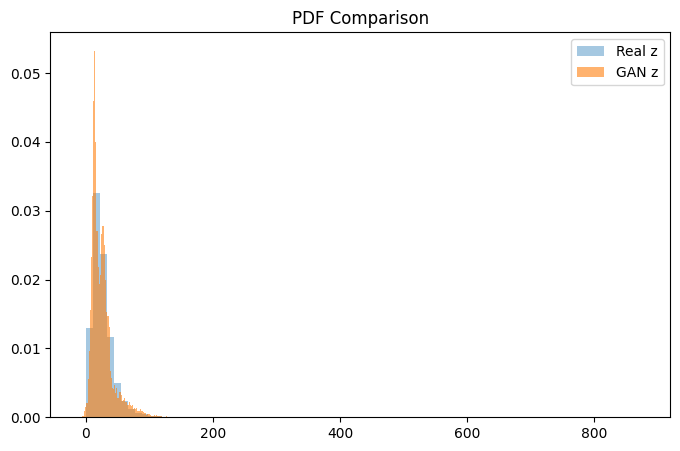

In [15]:
plt.figure(figsize=(8,5))
plt.hist(z, bins=80, density=True, alpha=0.4, label="Real z")
plt.hist(gen_z, bins=80, density=True, alpha=0.6, label="GAN z")
plt.title("PDF Comparison")
plt.legend()
plt.show()

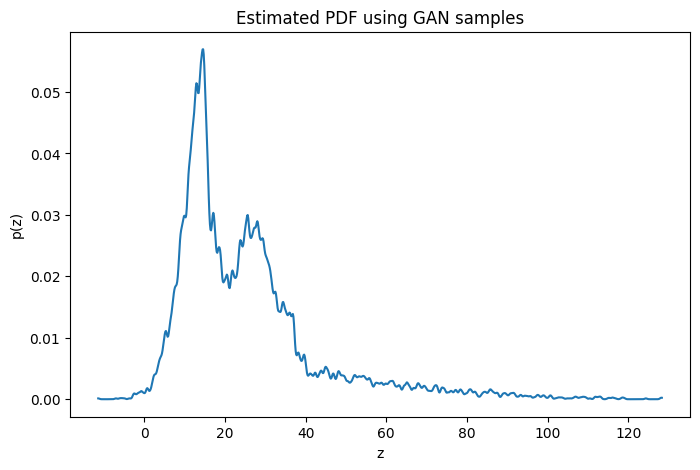

In [16]:
gen_z = gen_z.reshape(-1, 1)

kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(gen_z)

z_range = np.linspace(gen_z.min(), gen_z.max(), 1000).reshape(-1,1)
log_dens = kde.score_samples(z_range)

plt.figure(figsize=(8,5))
plt.plot(z_range, np.exp(log_dens))
plt.title("Estimated PDF using GAN samples")
plt.xlabel("z")
plt.ylabel("p(z)")
plt.show()

In [19]:
plt.savefig("histogram.png", dpi=300, bbox_inches='tight')
plt.savefig("kde_curve.png", dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>